# ML Applications to Project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

## Logistic Regression

In this study, we implemented Logistic Regression as a classification model to predict Autism Spectrum Disorder (ASD) diagnosis based on the given dataset.

To ensure a well-structured pipeline, we first preprocessed the data by converting all boolean values (True/False) to numerical (0/1).

In [5]:
df = pd.read_csv("earlyAutism.csv")

# Identify boolean columns
bool_cols = df.select_dtypes(include=["bool"]).columns

# Convert boolean values to 0/1 using .astype(int)
df[bool_cols] = df[bool_cols].astype(int)

# Define features (X) and target (y)
X = df.drop(columns=["class"])
y = df["class"].astype(int)  # Ensure target is integer

# Train/Test Split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

- We applied MinMax Scaling to normalize the feature values between 0 and 1. 

- We performed hyperparameter tuning using GridSearchCV with a 5-fold cross-validation approach. The hyperparameters tested included regularization strength (C) and penalty type (L1, L2), while using the "liblinear" solver which supports L1 regularization.

- The best combination of hyperparameters found was C=10, penalty=L1, meaning the model benefited from a stronger regularization effect.

In [7]:
# Standardization (Recommended for Logistic Regression)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Logistic Regression Model
log_reg = LogisticRegression()

# Define Hyperparameter Grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "penalty": ["l1", "l2"],  # Regularization type
    "solver": ["liblinear"]  # Compatible with L1 penalty
}

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best Model
best_log_reg = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


- The confusion matrix shows that the model predicted 30 No-ASD cases correctly, with only 1 misclassified as ASD. For ASD cases, it correctly predicted all 28 ASD cases with zero false negatives.

- These results indicate that Logistic Regression is highly effective in predicting ASD based on the given dataset. The high recall for ASD cases (1.00) is particularly important because missing an ASD diagnosis could lead to delayed interventions. The model’s single false positive suggests that it is slightly conservative in predicting ASD, but this is preferable to missing actual ASD cases.

- We will compare the performance of Logistic Regression model with other models such as Random Forest, SVM, and XGBoost to see if any of them offer further improvements.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.97      1.00      0.98        28

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59

Accuracy: 0.9830508474576272


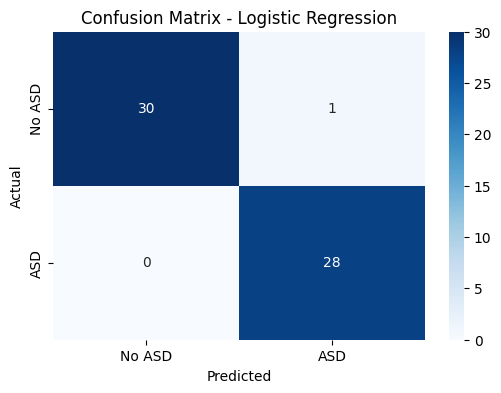

In [8]:
# Evaluate on Test Set
y_pred = best_log_reg.predict(X_test_scaled)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Random Forest 

The Random Forest model was implemented to predict Autism Spectrum Disorder (ASD) diagnosis.

In [11]:
rf = RandomForestClassifier(random_state=42)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Using GridSearchCV with 5-fold cross-validation, we optimized key hyperparameters. The final model used 200 trees (n_estimators=200), no depth limit (max_depth=None), a minimum of 2 samples per leaf (min_samples_leaf=2), and a minimum of 2 samples required to split (min_samples_split=2).

In [16]:
# Define Hyperparameter Grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [None, 10, 20],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples required to split a node
    "min_samples_leaf": [1, 2, 5]  # Min samples required in a leaf node
}

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


- The confusion matrix indicates a strong classification ability, with 30 correct No-ASD predictions and 27 correct ASD predictions, and only one misclassification in each class. 

- The classification report confirms an accuracy of 96.6%, with precision and recall scores around 0.96 to 0.97 for both classes. 

- The high recall for ASD cases (0.96) is particularly crucial since it means very few ASD cases were misclassified. This is important in the context of autism detection, where minimizing false negatives is essential for early intervention.


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.96      0.96      0.96        28

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

Accuracy: 0.9661016949152542


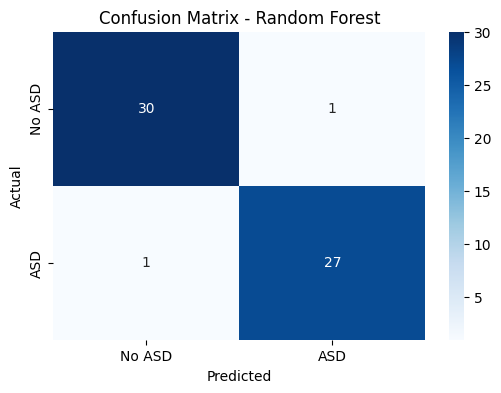

In [14]:
# Evaluate on Test Set
y_pred = best_rf.predict(X_test)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

- The feature importance graph highlights which features contributed most to the model’s decision-making. The AQ-10 questionnaire scores (A1_Score to A10_Score) dominated the top rankings, particularly A4_Score, A9_Score, and A10_Score. 

- Specific behavioral indicators in the screening questionnaire play a critical role in ASD detection. 

- Among demographic features, age, gender, ethnicity (White-European), and country of residence (United States) were also relevant, though less influential than the behavioral scores.

- These findings reinforce the significance of behavioral screening scores in ASD diagnosis and suggest that demographic factors contribute but are not primary determinants. 

- The model's high accuracy and balanced precision-recall performance make it a reliable classifier, potentially more interpretable than deep learning-based methods. However, further testing on unseen datasets and comparison with models like SVM and XGBoost will help determine the most optimal approach for real-world application.

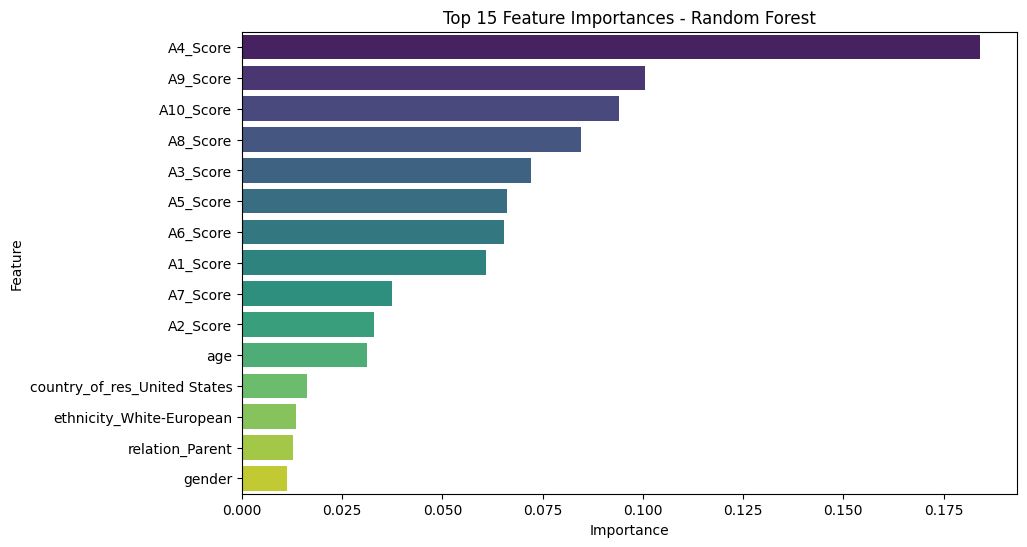

In [15]:
# Feature Importance Plot
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": best_rf.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances[:15], palette="viridis", hue = "Feature")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

## Support Vector Machine (SVM)

The Support Vector Machine (SVM) model was implemented to classify individuals based on the likelihood of an Autism Spectrum Disorder (ASD) diagnosis.

In [21]:
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)

# Define SVM Model
svm = SVC()

- We performed hyperparameter tuning using GridSearchCV, testing different kernel types (linear, rbf, poly), regularization strengths (C), and kernel coefficients (gamma). 

- The best configuration found was C=10, gamma='scale', and kernel='linear', indicating that a linear decision boundary was sufficient for effective classification.

In [22]:
# Define Hyperparameter Grid
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ["linear", "rbf", "poly"],  # Type of decision boundary
    "gamma": ["scale", "auto"]  # Kernel coefficient
}

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_svm, y_train)

# Best Model
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


- The confusion matrix reveals a perfect classification, correctly predicting all 31 No-ASD cases and all 28 ASD cases with zero misclassifications. 

- The classification report confirms a 100% accuracy, with both precision and recall values at 1.00 for both classes. This suggests that the model has completely separated the ASD and No-ASD classes in the dataset.

A perfect accuracy score can sometimes indicate overfitting, meaning the model might not generalize well to unseen data. This could be due to:

- Clear separability of ASD and No-ASD groups in the dataset, making classification easy.
- Small dataset size, which can sometimes lead to overly optimistic results.
- Potential data leakage, if preprocessing steps inadvertently introduced information from the test set.

To confirm the model’s robustness, it should be validated on an external dataset.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        28

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

Accuracy: 1.0


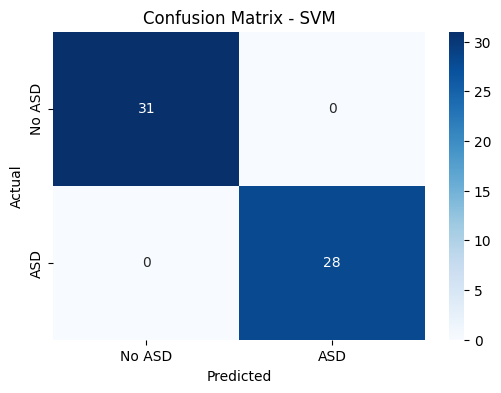

In [23]:
# Evaluate on Test Set
y_pred = best_svm.predict(X_test_svm)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()